In [6]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy import signal
from scipy.io import wavfile
import sounddevice as sd
from scipy.io.wavfile import write

%matplotlib inline

# Input one fixed audio

In [10]:
fft_length = 4096
fs = 44100  # Sample rate
seconds = 2  # Duration of recording

In [29]:
input_source = np.zeros(fft_length)
input_source[1] = 1

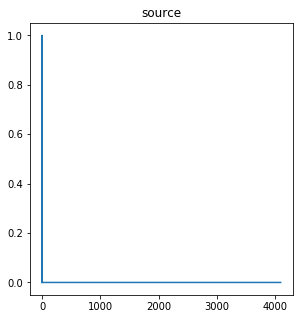

In [30]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.title('source')
plt.plot(input_source)

# Generate DTF of the input

In [31]:
input_fft = np.fft.rfft(input_source_1, fft_length)
frequency = np.linspace(0,fs/2,len(input_fft))

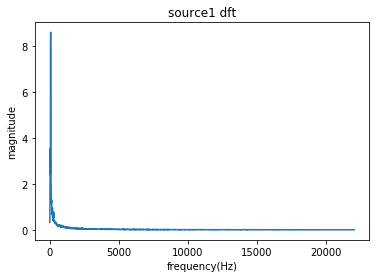

In [32]:
plt.figure()
plt.title("source1 dft")
plt.xlabel('frequency(Hz)')
plt.ylabel('magnitude')
plt.plot(frequency, np.absolute(input_fft))

# Play the sound using different earphones and record it from the same microphone(Iphone8 mic next to the lightning port)

## Here three earphones are used, airpods pro, ie40 pro, and sephia SP3060
## Use each eaphone to record the input sound three times in case the noise provides some features

In [33]:
Audio(data=input_source_1, rate=fs)

In [34]:
folder_name = 'recording/'
def plot_audio(subplot_num, title, data):
    plt.subplot(subplot_num)
    plt.title(title)
    plt.xlabel("samples")
    plt.ylabel("magnitude")
    plt.plot(data)

# this function is used to find the correct piece of audio recorded
# use the maximum value index as a clip
def clip_recording(audio):
    index = np.argmax(audio)
    return audio[index:index+fft_length]

# Read the recorded audio

/Users/weiyang/opt/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


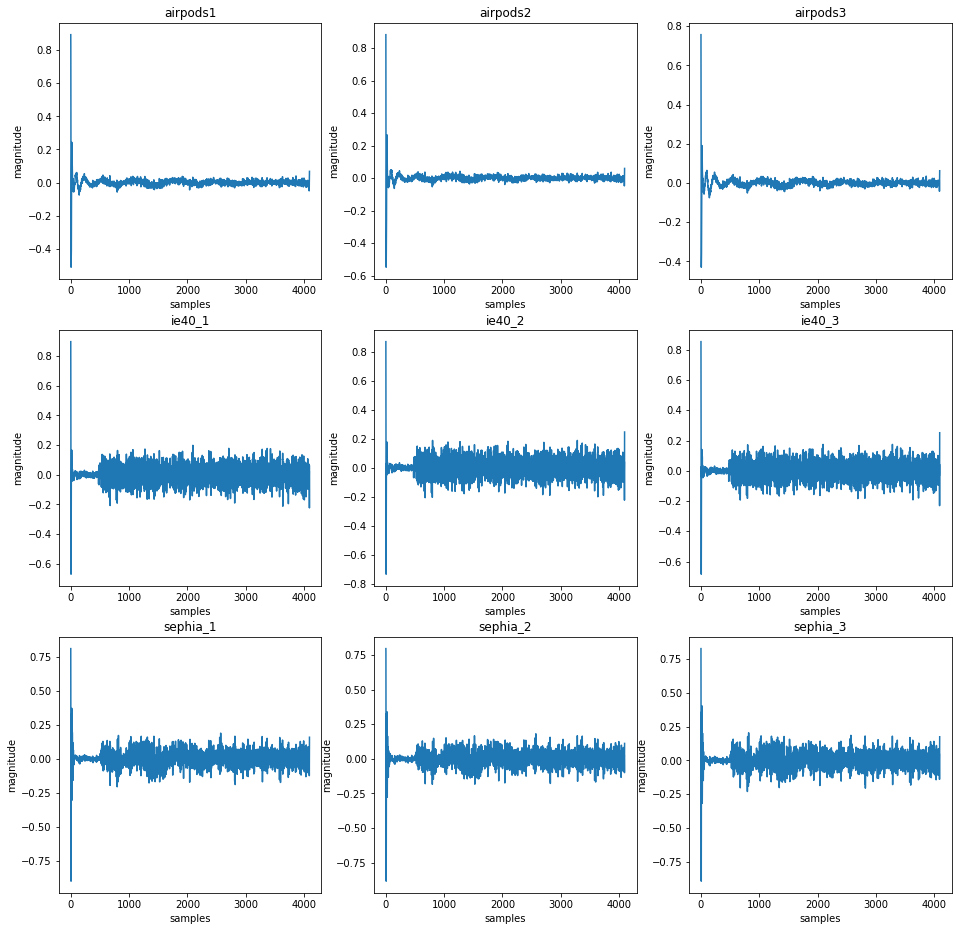

In [35]:
_, ie40_1 = wavfile.read(folder_name+"ie40_1.wav")
_, ie40_2 = wavfile.read(folder_name+"ie40_2.wav")
_, ie40_3 = wavfile.read(folder_name+"ie40_3.wav")
_, sephia_1 = wavfile.read(folder_name+"sephia_1.wav")
_, sephia_2 = wavfile.read(folder_name+"sephia_2.wav")
_, sephia_3 = wavfile.read(folder_name+"sephia_3.wav")
_, airpods_1 = wavfile.read(folder_name+"airpods_1.wav")
_, airpods_2 = wavfile.read(folder_name+"airpods_2.wav")
_, airpods_3 = wavfile.read(folder_name+"airpods_3.wav")


# clip the played sound
ie40_1 = clip_recording(ie40_1)
ie40_2 = clip_recording(ie40_2)
ie40_3 = clip_recording(ie40_3)
sephia_1 = clip_recording(sephia_1)
sephia_2 = clip_recording(sephia_2)
sephia_3 = clip_recording(sephia_3)
airpods_1 = clip_recording(airpods_1)
airpods_2 = clip_recording(airpods_2)
airpods_3 = clip_recording(airpods_3)

# display in time domain
plt.figure(figsize=(16, 16))
plot_audio(331, 'airpods1', airpods_1)
plot_audio(332, 'airpods2', airpods_2)
plot_audio(333, 'airpods3', airpods_3)
plot_audio(334, 'ie40_1', ie40_1)
plot_audio(335, 'ie40_2', ie40_2)
plot_audio(336, 'ie40_3', ie40_3)
plot_audio(337, 'sephia_1', sephia_1)
plot_audio(338, 'sephia_2', sephia_2)
plot_audio(339, 'sephia_3', sephia_3)

# Generate transfer funtions for each earphone
### Here only three earphones are used.
### Each earphone is measured by three times to make sure the feature of the estimated transfer function does not come from the noise channel

In [53]:
def generate_transfer(input_fft, output_audio):
    output_fft = np.fft.rfft(output_audio, fft_length)
    return output_fft / input_fft

frequency = np.linspace(0,fs/2,len(input_fft))
def plot_transfer(subplot_num, title, data, magnitude=True):
    plt.subplot(subplot_num)
    plt.title(title)
    plt.xlabel("frequency(Hz)")
    if (magnitude):
        plt.ylabel("magnitude(dB)")
    else:
        plt.ylabel("Phase(rad)")
    plt.plot(frequency, data)
    

In [54]:
ie40_transfer_1 = generate_transfer(input_fft, ie40_1)
ie40_transfer_2 = generate_transfer(input_fft, ie40_2)
ie40_transfer_3 = generate_transfer(input_fft, ie40_3)

sephia_transfer_1 = generate_transfer(input_fft, sephia_1)
sephia_transfer_2 = generate_transfer(input_fft, sephia_2)
sephia_transfer_3 = generate_transfer(input_fft, sephia_3)

airpods_transfer_1 = generate_transfer(input_fft, airpods_1)
airpods_transfer_2 = generate_transfer(input_fft, airpods_2)
airpods_transfer_3 = generate_transfer(input_fft, airpods_3)

#### Below shows the magnitude of transfer functions of three earphones

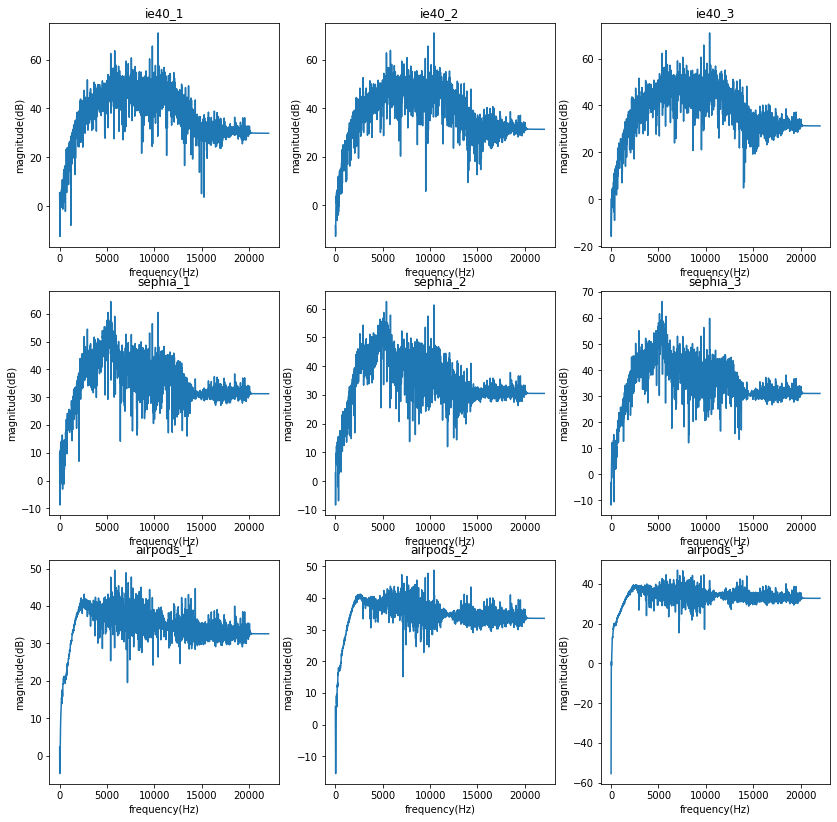

In [61]:

plt.figure(figsize=(14, 14))
plot_transfer(331, 'ie40_1', 20*np.log10(np.absolute(ie40_transfer_1)))
plot_transfer(332, 'ie40_2', 20*np.log10(np.absolute(ie40_transfer_2)))
plot_transfer(333, 'ie40_3', 20*np.log10(np.absolute(ie40_transfer_3)))
plot_transfer(334, 'sephia_1', 20*np.log10(np.absolute(sephia_transfer_1)))
plot_transfer(335, 'sephia_2', 20*np.log10(np.absolute(sephia_transfer_2)))
plot_transfer(336, 'sephia_3', 20*np.log10(np.absolute(sephia_transfer_3)))
plot_transfer(337, 'airpods_1', 20*np.log10(np.absolute(airpods_transfer_1)))
plot_transfer(338, 'airpods_2', 20*np.log10(np.absolute(airpods_transfer_2)))
plot_transfer(339, 'airpods_3', 20*np.log10(np.absolute(airpods_transfer_3)))

#### Below shows the phase of transfer functions of three earphones

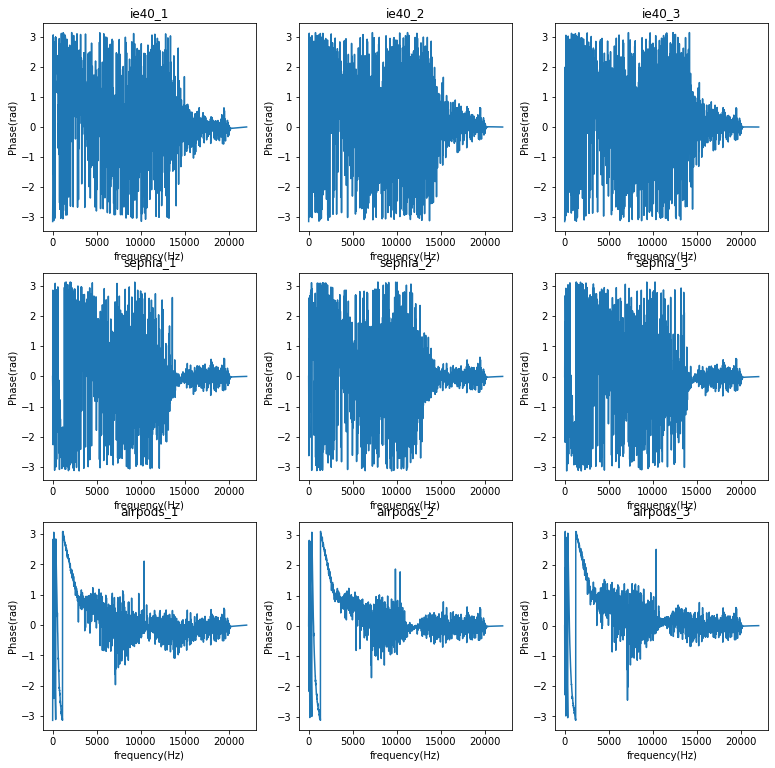

In [62]:
plt.figure(figsize=(13, 13))
plot_transfer(331, 'ie40_1', np.angle(ie40_transfer_1), 0)
plot_transfer(332, 'ie40_2', np.angle(ie40_transfer_2), 0)
plot_transfer(333, 'ie40_3', np.angle(ie40_transfer_3), 0)
plot_transfer(334, 'sephia_1', np.angle(sephia_transfer_1), 0)
plot_transfer(335, 'sephia_2', np.angle(sephia_transfer_2), 0)
plot_transfer(336, 'sephia_3', np.angle(sephia_transfer_3), 0)
plot_transfer(337, 'airpods_1', np.angle(airpods_transfer_1), 0)
plot_transfer(338, 'airpods_2', np.angle(airpods_transfer_2), 0)
plot_transfer(339, 'airpods_3', np.angle(airpods_transfer_3), 0)